In [1]:
# we consider a least square problem, f(x) = (Ax-b)^2
import numpy as np
import numpy.linalg as la
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from math import sqrt


import warnings
warnings.filterwarnings("error")

In [2]:
np.random.seed(seed=42)
agent_num = 10

d=100
data_num = 20
# x_opt = np.ones((d))/d
x_opt = np.random.randn(d)+10
x_local_opt = np.tile(x_opt,(agent_num, 1))
x_local_opt = x_local_opt+  np.random.rand(agent_num, d)
# print(x_local_opt[:,0])
# P = ortho_group.rvs(d)
A = np.zeros((agent_num, data_num, d))
b = np.zeros((agent_num, data_num))

for i in range(agent_num):
    P = ortho_group.rvs(d)
    eigv = (np.random.rand(d))
    eigv[0:5] = np.zeros(5)
    A_temp = np.matmul( np.diag(eigv), P)
    A[i] = A_temp[0:data_num,:]
# A = np.matmul(np.transpose(P), np.matmul( np.diag(eigv), P))
# x_opt = np.random.rand(d)
    b[i] = np.matmul( A[i], x_local_opt[i])
    
    
# filename = "d_1000_n_10"
# np.save(filename+"_A", A)
# np.save(filename+"_b", b)
# np.save(filename+"_x", x_opt)
print(np.linalg.matrix_rank(np.matmul(np.transpose(A[1]), A[1])))


15


7.458751749331938


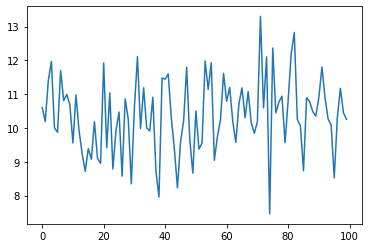

In [5]:
# gamma = np.load("gamma.npy")

# # we first try to calculate the real optimal x_star
A_stack = np.reshape(A, (200,100))
b_stack = np.reshape(b, (200))


# C = np.zeros((d,d-1))
# for i in range(d-1):
#     C[i,i] = 1
# C[d-1,:]=-1
# # print(C)
# A_prime = np.matmul(A_stack, C)

# c_vector = np.zeros((d))
# c_vector[-1]=1
# # print(c_vector)
# b_prime = b_stack - np.matmul(A_stack, c_vector)


# pinv_A = np.linalg.pinv(A_prime)
# x_temp = np.matmul(pinv_A, b_prime)
# x_direct = np.zeros((d))
# x_direct[:d-1] = x_temp
# x_direct[d-1] = 1 - np.sum(x_temp)
# print(x_direct[0])
# error = np.matmul(A_stack, x_direct)-b_stack
# loss_star = np.matmul(np.transpose(error), error)
# print(np.sum(loss_star))
pinv_A = np.linalg.pinv(A_stack)
x_direct = np.matmul(pinv_A, b_stack)
# print(x_direct[0])
error = np.matmul(A_stack, x_direct)-b_stack
loss_star = np.matmul(np.transpose(error), error)
plt.plot(x_direct)
print(np.min(x_direct))


nabla_phi = np.eye(d)+0.1*np.ones((d,d))
nabla_phi_star = np.linalg.pinv(nabla_phi)

In [16]:
import time

x_0 = np.random.rand(agent_num, d)

#first is gradient Descent
iter_num = 1000000
lr = 1
time_int = 0.1

x_k = np.zeros((agent_num,d))
x_k1 = np.zeros((agent_num,d))

z_k = np.zeros((agent_num,d))
z_k1 = np.zeros((agent_num,d))
# x_k2 = np.zeros((agent_num,d))
y_k = np.zeros((agent_num,d))
y_k1 = np.zeros((agent_num,d))
# y_k2 = np.zeros((agent_num,d))
# x_accumulate = np.zeros((agent_num,d))
# y_accumulate = np.zeros((agent_num,d))


# z = np.zeros(d)
# loss_z = np.zeros((iter_num))
loss_x_global = np.zeros((agent_num, iter_num))
# accu_x_record = np.zeros((iter_num))
# accu_y_record = np.zeros((iter_num))
x_record = np.zeros((iter_num))
x_mean = np.zeros((iter_num))
loss = np.zeros((agent_num, iter_num))




# z = np.mean(x_0, axis = 0)
# for i in  range(agent_num):

#     x_k[i] = np.copy(x_0)
x_k = np.copy(x_0)
# print(x_k[1,:].shape)
# 
z_k =  np.copy(x_k)
for i in range(agent_num):
    z_k[i,:] =   np.matmul(nabla_phi, x_k[i,:])

# 
for k in tqdm(range( iter_num)):
    for i in range(agent_num):

        gradient_k1 = np.matmul(np.transpose(A[i]), (np.matmul(A[i], x_k[i,:])-b[i]))
        y_k1[i,:] = y_k[i,:] + time_int*(x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:])
        z_k1[i,:] = z_k[i,:] - time_int*(lr*gradient_k1 - y_k[i,:] - (x_k[(i+1)%agent_num,:]+x_k[(i-1)%agent_num,:] - 2*x_k[i,:]))

        error = np.matmul(A[i], x_k1[i,:])-b[i]
        loss[i, k] = np.matmul(np.transpose(error), error)
        
#    change mirror method     
    for i in range(agent_num):
#         x_k[i,:] = np.exp(z_k1[i,:])/np.exp(1)
        x_k[i,:] = np.matmul(nabla_phi_star, z_k1[i,:])
#         print(np.max(x_k[i,:]))
#         x_k[i,:] = np.exp(z_k1[i,:])/sum(np.exp(z_k1[i,:]))
#     
    
    z_k = np.copy(z_k1)
    y_k = np.copy(y_k1)

#     z = np.mean(x_k, axis = 0)
#     print(z[0])
#     for i in range(agent_num):
#     error = np.matmul(A_stack, z)-b_stack
#     loss_z[k] = np.matmul(np.transpose(error), error)
    temp_sum = 0
    x_bar = np.mean(x_k, axis=0)
    for agent in range(agent_num):
        temp_sum += np.linalg.norm(x_k[agent,:]-x_bar)
    x_record[k] = temp_sum/agent_num
    for i in range(agent_num):
#         print(x_k[i,:])
#         np.matmul(A_stack, )
        error = np.matmul(A_stack, x_k[i,:])-b_stack
        loss_x_global[i,k] = np.matmul(np.transpose(error), error)
#         if((loss_x_global[i,k]-loss_star)< 0.01):
#             print("reached")
#             reach=0
#             time.sleep(3600)



    

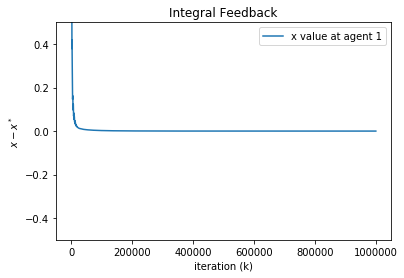

In [13]:
plt.plot(x_record, label='x value at agent 1')
# plt.plot(x_mean, label='x value of global average')
# plt.scatter(accu_x_record[1:])
# plt.plot(gamma[1:20000])
y_range = 0.5
plt.ylim((-y_range,y_range))

plt.xlabel('iteration (k)')
plt.ylabel('$x - x^*$')
# ax.annotate('', xy=(0.99, 0), ha='left', va='top', xycoords='axes fraction', fontsize=8)
plt.title("Integral Feedback")

plt.legend(loc='upper right')

# print(accu_x_record[-1])x_k[i,:]
# plt.xlabel("x_tilde value")
# plt.savefig("consensus_proposed")
# print(gamma[100000])

In [36]:
# plt.plot(x_record[1000000:])
# plt.plot(gamma[1:20000])
# plt.ylim((-5e10,5000000))
# print(x_record[-1])
# plt.xlabel("local x value")

# plt.savefig("non_accel_EXTRA x_record 5m_it over_k")

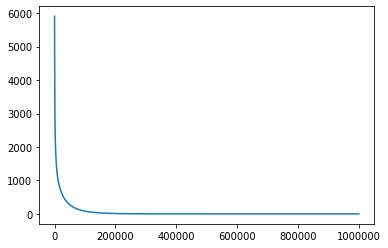

In [14]:
# loss_z_k2 = (loss_z-loss_star)*range(iter_num)*range(iter_num)
# loss_z_k1 = (loss_z-loss_star)*range(iter_num)
plt.plot(loss_x_global[0,:]-loss_star)
# plt.ylim((-0.01,0.05))
# print(loss_z_k2[1:].min())
# print((loss_z*range(iter_num))[-1])
# plt.xlabel("(loss-loss*)xk^2")
# plt.savefig("non_accel_EXTRA (loss-loss_star)k 5m_it over_k")
# loss_star_global
# plt.savefig("100k_simplex_loss")

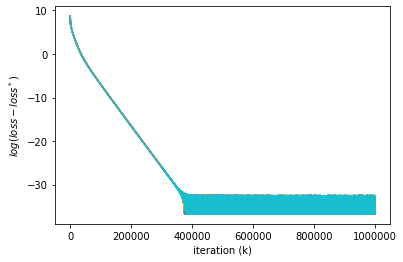

In [18]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')
for i in range(10):
    
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)*range(iter_num)
    loss_x = (loss_x_global[i,:]-loss_star)
#     loss_x_k2 = (loss_x_global[i,:])*range(iter_num)*range(iter_num)
#     loss_x_k2 = (loss_x_global[i,:]-loss_star)*range(iter_num)
    plt.plot(np.log(loss_x[1:]))
# loss_x2_k2 = (loss[1,:]-loss_star)*range(iter_num)*range(iter_num)
plt.xlabel('iteration (k)')
plt.ylabel('$log(loss - loss^*)$')

plt.savefig("loss-loss_star_ten")

# plt.plot(loss_x2_k2[1:])
# plt.ylim((0,1))
# print(loss_x_k2[1:].min())
# print(loss_z*range(30000)[-1])
# plt.xlabel("(loss-loss*)xk^2")


In [35]:
# np.save("100d_simplex_1m_loss", loss_x_global)
# np.save("100d_simplex_1m_loss_star", loss_star)
# np.save("100d_simplex_1m_x_minus_bar", x_record)
# np.save(outfile, x)